# Define clusters 

In [2]:
#load datasets
import geopandas as gpd
import pandas as pd
from constants import loading_dict, temporal_buffer, ddataset_profile, ddisturbance_profile, DCLASS_SCORE, dtypes, doa, dsbuffer

ddataset = {dataset_name : gpd.read_parquet(dataset_path) for dataset_name, dataset_path in loading_dict.items()}

#preprocessing tcl:
tcl = gpd.read_parquet('../data/processed_datasets/simplified_TreeCoverLoss_2001-2022_EPSG2154_FR.parquet')
tcl['year'] = tcl['year'] + 2000
tcl['class'] = None

#preprocessing bdiff:

ddataset['firepolygons']['class'] = 'Fire'
#add end date with offset of 7 days 
ddataset['firepolygons']['end_date'] = pd.to_datetime(ddataset['firepolygons']['start_date']) + pd.to_timedelta(7, unit='d')

ddataset['bdiff']['class'] = 'Fire'
ddataset['bdiff'] = ddataset['bdiff'][ ddataset['bdiff'].forest_area_m2 > 5000 ]
#filter bdiff geometry area < 100 1e6  m2
ddataset['bdiff'] = ddataset['bdiff'][ ddataset['bdiff'].geometry.area <= 100e6 ]
#same for cdi 
ddataset['cdi'] = ddataset['cdi'][ ddataset['cdi'].geometry.area <= 100e6 ]
#create function that convert column 'start_date' to pd.datetime with the following format : '%Y-%m-%d', 
# if the 'start_date' is just mentionning the time and not the date, use the year column to create a start_date and end_date column as the first and last day of this year
#create this function as 'to_datetime_safe', it takes as input a row of a dataframe
def to_datetime_safe(row):
    try :
        return pd.to_datetime(row['start_date'], format='%Y-%m-%d'), pd.to_datetime(row['start_date'], format='%Y-%m-%d')
    except ValueError:
        return pd.to_datetime(row['year'], format='%Y'), pd.to_datetime(row['year'], format='%Y') + pd.offsets.YearEnd(0)


ddataset['bdiff'][['start_date', 'end_date']] = ddataset['bdiff'].apply(to_datetime_safe, axis=1, result_type='expand')

#autoreload 
from attribution2 import Attribution
attribution = Attribution(ddataset, reference=tcl, doa=doa, dtypes=dtypes, 
                          temporal_buffer=temporal_buffer, dsbuffer=dsbuffer, 
                          dclass_score=DCLASS_SCORE, granularity=5, 
                          ddataset_profile=ddataset_profile, ddisturbance_profile=ddisturbance_profile, 
                          start_year=2017)

filter_class = set()
for dataset, dclass in DCLASS_SCORE.items():
    for class_ in dclass:
        if 'storm' in dclass[class_] or 'fire' in dclass[class_]:
            filter_class.add(class_)

In [3]:
#load communities 
mode = 'equal'
resolution = 100
dim = 2
temporal_threshold_ = 180 * 2
spatial_threshold_  = 600

all_clusters_gdf = gpd.read_parquet(f"../data/results/clusters/communities_d{dim}_r{resolution}_g{attribution.granularity}_{spatial_threshold_}m_{temporal_threshold_}d_v{attribution.version}.parquet")


In [4]:
from utils import compute_spatial_distance_v2, compute_tree_coherence_v2, compute_class_similarity_v2
weights = {
    'equal' : [0.25, 0.25, 0.25, 0.25],
    'PCA' : [0.23017731, 0.40759976, 0.20566699, 0.15655594],
    'ECO' : [2, 2, 1, 3]
}
kwds = {
    'DBSCAN': {'eps': 0.7, 'min_samples': 2},
    'HDBSCAN': {'min_cluster_size': 2}
}

filter_class = set()
for dataset, dclass in DCLASS_SCORE.items():
    for class_ in dclass:
        if 'storm' in dclass[class_] or 'fire' in dclass[class_]:
            filter_class.add(class_)
dcustom_similarity_function_v2 = {'spatial_distance': (compute_spatial_distance_v2, {'final_weighting_dict': attribution.final_weighting_dict}), 
                                  'tree_coherence': (compute_tree_coherence_v2, {'filter_cause': filter_class}), 
                                  'class_similarity': (compute_class_similarity_v2, {'dclass_score': DCLASS_SCORE})}

In [5]:
mode = 'equal'
method = 'HDBSCAN'

In [6]:
from utils import get_cluster_v2, get_matrices_v2, build_similarity_v2
import warnings
import time
from joblib import Parallel, delayed
from itertools import islice
from sklearn.metrics import silhouette_score
from tqdm import tqdm
from collections import defaultdict
import os 
import numpy as np 

all_clusters_gdf_v2 = all_clusters_gdf.rename(columns={'class': 'cause'})


groups = all_clusters_gdf_v2.groupby('cluster')
std = np.std([len(g) for g in groups])
median = np.median([len(g) for g in groups])

#compute the foux matrices of similarities 
print(f'computing the four matrices for {len(groups)} communities...')
start = time.time()
list_matrices = []
with warnings.catch_warnings():
    
    warnings.filterwarnings("ignore", category=DeprecationWarning)
    for i in tqdm(range(0, len(groups), 1000)):
        r = Parallel(n_jobs=-1, prefer='processes', verbose=0)(delayed(get_matrices_v2)(data,  dtypes, dcustom_similarity_function_v2, attribution.final_weighting_dict) for _,data in islice(groups, i, min(len(groups), i+1000)))
        list_matrices.extend(r)

end = time.time()
print(f'elapsed time : {end - start :.2f}s')

weight = weights[mode]
#building all the similiarty matrix
matrices = Parallel(n_jobs=-1, prefer='threads', verbose=0)(delayed(build_similarity_v2)(m, weight) for m in list_matrices)

#disturb time period and polygons 
list_gdf = []
list_labels = []
list_sim_matrices = []
kwargs = kwds[method]
for i in tqdm(range(0, len(groups), 1000)):
    r = Parallel(n_jobs=-1, prefer='processes', verbose=0)(delayed(get_cluster_v2)(data, m, attribution.final_weighting_dict, attribution.doa, DCLASS_SCORE, method=method, method_kwargs=kwargs) for (_,data), m in zip(islice(groups, i, min(len(groups), i+1000)), islice(matrices, i, min(len(matrices), i+1000))))
    for x in r:
        list_gdf.append(x[0])
        list_sim_matrices.append(x[1])
        list_labels.append(x[2])
end = time.time()
print(f'elapsed time : {end - start :.2f}s')

#save gdf
df = pd.concat(list_gdf)
gdf = gpd.GeoDataFrame(df, geometry='geometry', crs=attribution.dataset.crs)
gdf = gdf[~gdf.is_empty]
gdf.to_parquet(f"../data/results/clusters/clusters_{method}_m{mode}_d{dim}_r{resolution}_g{attribution.granularity}_{spatial_threshold_}m_{temporal_threshold_}d_v{attribution.version}.parquet")

#SILHOUETTE SCORE
print('computing silhouette score...')
silhouette_scores = []
for similarity_matrix, labels in zip(list_sim_matrices, list_labels):
    # Ensure that labels have at least one cluster and less than n_samples clusters
    if 1 < len(set(labels)) < len(labels):
        # Convert similarity matrix to distance matrix if necessary
        distance_matrix = 1 - similarity_matrix
        
        # Calculate the Davies-Bouldin Score
        silhouette = silhouette_score(X=distance_matrix, labels=labels, metric='precomputed')
        silhouette_scores.append(silhouette)


#LABELSIZE
#I want to know the size of each label in each l of list_labels
label_size = [np.unique(l, return_counts=True)[1] for l in list_labels]
#flatten the list
label_size = [item for sublist in label_size for item in sublist]

#count the number of label == -1 to know the noise level
noise = sum([1 if -1 in l else 0 for l in list_labels]) / len(label_size)


#label size without noise
label_size = [np.unique([x for x in l if x!=-1], return_counts=True)[1] for l in list_labels]
#flatten the list
label_size = [item for sublist in label_size for item in sublist]



computing the four matrices for 30496 communities...


100%|██████████| 31/31 [31:47<00:00, 61.54s/it]


elapsed time : 1907.83s


100%|██████████| 31/31 [1:24:12<00:00, 162.97s/it]


elapsed time : 6965.39s
computing silhouette score...


In [7]:
noise

0.10981707391982702

In [8]:
gdf['Class'].value_counts()

Class
anthropogenic       202789
storm                23143
biotic-dieback        6854
fire                  5314
biotic-mortality      4580
drought-dieback       1147
Name: count, dtype: int64

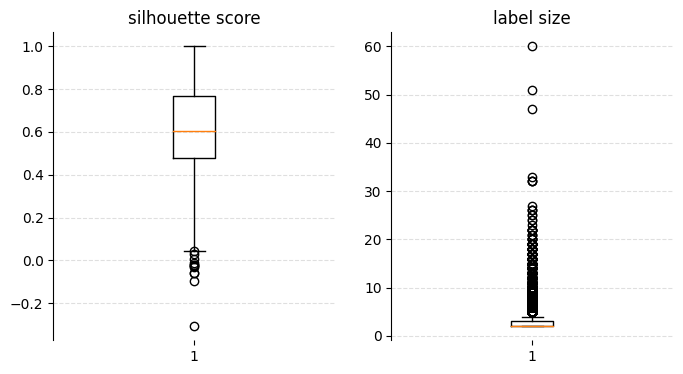

In [9]:
#display boxplot of silhouette score and label_size
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].boxplot(silhouette_scores)
ax[0].set_title('silhouette score')
ax[1].boxplot(label_size)
ax[1].set_title('label size')

for a in ax:
    a.spines['top'].set_visible(False)
    a.spines['right'].set_visible(False)
    a.spines['bottom'].set_visible(False)
    #horizontal grid
    a.yaxis.grid(True, linestyle='--', which='major', color='grey', alpha=.25)